## Estimate Fuel use with vessel speed, h_0, current speed as input

### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages



### create graph with navigation info

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4366,0],
    [0.8528,0], 
    [1.1443,0],
    [1.31495,0],
    [1.56274,0],
    [1.736384,0],
    [2.0710,0], 
    [2.20665,0],
    [3.05674,0],
    [3.32804,0],
    [4.1148,0],
    [4.54888,0], 
    [4.73879,0],
    [5.07844,0],
    [6.62475,0], 
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [7.5, 4.18, 4.18, 7.83, 7.5, 6.5, 10.6, 6.45, 8.04, 5.65, 8.87, 4.93, 7.7, 9.8, 5.45]
current_speeds = [-2.24* 0.2777,-3.4* 0.2777,-4.93* 0.2777,-2.59* 0.2777,-3.26* 0.2777,
                     -3.85* 0.2777,-1.87* 0.2777,-1.08* 0.2777,-2.83* 0.2777,-4.99* 0.2777,
                     -2.89* 0.2777,-6.4* 0.2777,-3.42* 0.2777,-1.64* 0.2777,-4.1* 0.2777]  # [m/s]

V_g_profile_up = [4.361618,3.545952,3.120952,4.277794,4.078284,3.760506,4.618420,4.507951,
4.233642,3.495985,4.244119,2.925416,4.042063,3.302698,3.632716]

V_g_profile_down = [4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 4.44, 4.44, 4.44,4.44, 4.44, 4.44, 3.33, 4.44] # [m/s] for downstream

# power_applied = [620, 620, 620, 620, 620, 620, 620, 620, 620,620, 620, 620,620, 250, 620] ## [kW] for upstream
# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

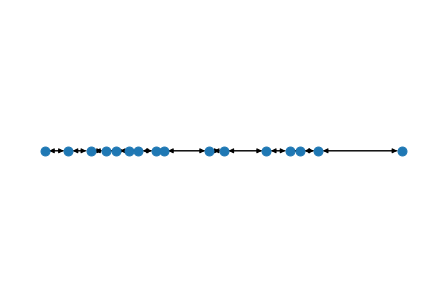

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {} m'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))
    print('Current speed for edge {} is {} m/s'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["CurrentSpeed"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing upstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_upstream"]))
    print('Vessel Speed To Ground for edge {} is {} m/s while sailing downstream'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["VesselSpeedToGroundProfile_downstream"]))

General depth for edge ('Node 0', 'Node 1') is 7.5 m
Current speed for edge ('Node 0', 'Node 1') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.361618 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 0', 'Node 1') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 0') is 7.5 m
Current speed for edge ('Node 1', 'Node 0') is -0.622048 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.361618 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 0') is 4.44 m/s while sailing downstream
General depth for edge ('Node 1', 'Node 2') is 4.18 m
Current speed for edge ('Node 1', 'Node 2') is -0.94418 m/s
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 3.545952 m/s while sailing upstream
Vessel Speed To Ground for edge ('Node 1', 'Node 2') is 4.44 m/s while sailing downstream
General depth for edge ('Node 2', 'Node 1') is 4.18 m
Current speed for edge ('Node 2', 'Node 1') is -0.94418 m/

### Create vessel - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel_up = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.4,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":True,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



In [8]:
# Create a dict with all important settings

data_vessel_down = {
    "env": None,
    "name": 'Vessel M6',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":4.44,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "H_e": None, 
    "H_f": None, 
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 780.0,   
    "P_tot_given": None, # kW
    "P_tot_given_profile":False,
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.064,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1961,
}             



### define sailing paths

In [9]:
path_upstream = nx.dijkstra_path(FG, nodes[0].name, nodes[15].name)
path_downstream = nx.dijkstra_path(FG, nodes[15].name, nodes[0].name)

### define simulation "Herso 1 sailing upstream and downstream"

In [10]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

### run simulation to get energy consumption

### upstream energy consumption

In [11]:
vessel_upstream = run_simulation(path = path_upstream, **data_vessel_up)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_upstream = opentnsim.energy.EnergyCalculation(FG, vessel_upstream)
energycalculation_upstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_upstream = pd.DataFrame.from_dict(energycalculation_upstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_upstream = df_upstream[selected]
df_upstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (0 0),POINT (0.4366 0),619.926814,780.0,2154.450098,4.858274e+05,0.570153,1.628764e+06,1266.816657,22594.320539,171090.798550,156713.420521,2.229000,2.041689,4.283702e+05,3.923727e+05,1.010343,0.925440,4.262861e+05,1.005427,1.041558e+06,9.540323e+05,1.314868,1.204375,1.036491e+06,1.308471,1.114936e+06,1.021244e+06,1.815012,1.662490,1.109512e+06,1.806182,2.448239e+07,19.374551,1.346531
1,POINT (0.4366 0),POINT (0.8528 0),619.768120,780.0,1849.923523,4.171568e+05,0.489564,1.398542e+06,1087.755031,19401.478176,146907.506991,134562.338337,1.913936,1.753101,3.678211e+05,3.369117e+05,0.867533,0.794631,3.660316e+05,0.863313,8.943364e+05,8.191821e+05,1.129015,1.034139,8.899853e+05,1.123522,9.573425e+05,8.768935e+05,1.558464,1.427501,9.526849e+05,1.550882,2.102186e+07,16.636003,1.156202
2,POINT (0.8528 0),POINT (1.1443 0),619.663945,780.0,1295.405518,2.921133e+05,0.342816,9.793266e+05,761.698445,13586.222836,102871.709479,94227.028011,1.340230,1.227606,2.575660e+05,2.359218e+05,0.607489,0.556439,2.563129e+05,0.604533,6.262574e+05,5.736307e+05,0.790590,0.724154,6.232106e+05,0.786744,6.703773e+05,6.140431e+05,1.091312,0.999605,6.671158e+05,1.086003,1.472052e+07,11.649330,0.809628
3,POINT (1.1443 0),POINT (1.31495 0),619.912433,780.0,844.330663,1.903961e+05,0.223444,6.383140e+05,496.466430,8854.765354,67050.616527,61416.110936,0.873547,0.800139,1.678786e+05,1.537712e+05,0.395954,0.362681,1.670619e+05,0.394028,4.081875e+05,3.738860e+05,0.515298,0.471995,4.062016e+05,0.512791,4.369443e+05,4.002263e+05,0.711305,0.651531,4.348186e+05,0.707844,9.594667e+06,7.592902,0.527707
4,POINT (1.31495 0),POINT (1.56274 0),619.893148,780.0,1222.660624,2.757093e+05,0.323565,9.243314e+05,718.924447,12822.497797,97094.837666,88935.607610,1.264968,1.158668,2.431021e+05,2.226734e+05,0.573374,0.525192,2.419194e+05,0.570585,5.910892e+05,5.414179e+05,0.746194,0.683489,5.882135e+05,0.742564,6.327315e+05,5.795608e+05,1.030028,0.943471,6.296532e+05,1.025017,1.389387e+07,10.995149,0.764163
5,POINT (1.56274 0),POINT (1.736384 0),619.862040,780.0,830.297880,1.872317e+05,0.219730,6.277052e+05,488.215154,8707.714948,65936.234739,60395.374677,0.859028,0.786841,1.650885e+05,1.512155e+05,0.389373,0.356653,1.642853e+05,0.387479,4.014034e+05,3.676720e+05,0.506734,0.464151,3.994505e+05,0.504268,4.296823e+05,3.935746e+05,0.699483,0.640703,4.275919e+05,0.696080,9.435203e+06,7.466708,0.518936
6,POINT (1.736384 0),POINT (2.071 0),619.934720,780.0,1702.261859,3.838592e+05,0.450486,1.286910e+06,1000.929973,17852.058782,135181.288740,123821.516577,1.761165,1.613168,3.384614e+05,3.100193e+05,0.798286,0.731203,3.368148e+05,0.794403,8.229501e+05,7.537946e+05,1.038896,0.951594,8.189463e+05,1.033842,8.809270e+05,8.068995e+05,1.434067,1.313557,8.766412e+05,1.427090,1.934388e+07,15.308110,1.063914
7,POINT (2.071 0),POINT (2.20665 0),619.963013,780.0,645.804967,1.456287e+05,0.170906,4.882286e+05,379.733321,6772.672512,51285.145855,46975.469733,0.668152,0.612004,1.284057e+05,1.176153e+05,0.30285

#### upstream_total_diesel_use [kg]

In [12]:
upstream_total_diesel_use = (df_upstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
upstream_total_diesel_use

6953.620066173873

### downstream energy consumption

In [13]:
vessel_downstream = run_simulation(path = path_downstream, **data_vessel_down)
# create an EnergyCalculation object and perform energy consumption calculation
energycalculation_downstream = opentnsim.energy.EnergyCalculation(FG, vessel_downstream)
energycalculation_downstream.calculate_energy_consumption()

# create dataframe from energy calculation computation
df_downstream = pd.DataFrame.from_dict(energycalculation_downstream.energy_use)
selected = ['edge_start','edge_stop','P_tot','P_installed','total_energy','total_diesel_consumption_ICE_mass','total_diesel_consumption_ICE_vol',
            'total_emission_CO2','total_emission_PM10','total_emission_NOX',
            'total_LH2_consumption_PEMFC_mass','total_LH2_consumption_SOFC_mass','total_LH2_consumption_PEMFC_vol','total_LH2_consumption_SOFC_vol',
           'total_eLNG_consumption_PEMFC_mass','total_eLNG_consumption_SOFC_mass','total_eLNG_consumption_PEMFC_vol','total_eLNG_consumption_SOFC_vol',
            'total_eLNG_consumption_ICE_mass','total_eLNG_consumption_ICE_vol',
            'total_eMethanol_consumption_PEMFC_mass','total_eMethanol_consumption_SOFC_mass','total_eMethanol_consumption_PEMFC_vol','total_eMethanol_consumption_SOFC_vol',
            'total_eMethanol_consumption_ICE_mass','total_eMethanol_consumption_ICE_vol','total_eNH3_consumption_PEMFC_mass','total_eNH3_consumption_SOFC_mass',
            'total_eNH3_consumption_PEMFC_vol','total_eNH3_consumption_SOFC_vol','total_eNH3_consumption_ICE_mass','total_eNH3_consumption_ICE_vol',
            'total_Li_NMC_Battery_mass','total_Li_NMC_Battery_vol','total_Battery2000kWh_consumption_num']
df_downstream = df_downstream[selected]
df_downstream

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



,edge_start,edge_stop,P_tot,P_installed,total_energy,total_diesel_consumption_ICE_mass,total_diesel_consumption_ICE_vol,total_emission_CO2,total_emission_PM10,total_emission_NOX,total_LH2_consumption_PEMFC_mass,total_LH2_consumption_SOFC_mass,total_LH2_consumption_PEMFC_vol,total_LH2_consumption_SOFC_vol,total_eLNG_consumption_PEMFC_mass,total_eLNG_consumption_SOFC_mass,total_eLNG_consumption_PEMFC_vol,total_eLNG_consumption_SOFC_vol,total_eLNG_consumption_ICE_mass,total_eLNG_consumption_ICE_vol,total_eMethanol_consumption_PEMFC_mass,total_eMethanol_consumption_SOFC_mass,total_eMethanol_consumption_PEMFC_vol,total_eMethanol_consumption_SOFC_vol,total_eMethanol_consumption_ICE_mass,total_eMethanol_consumption_ICE_vol,total_eNH3_consumption_PEMFC_mass,total_eNH3_consumption_SOFC_mass,total_eNH3_consumption_PEMFC_vol,total_eNH3_consumption_SOFC_vol,total_eNH3_consumption_ICE_mass,total_eNH3_consumption_ICE_vol,total_Li_NMC_Battery_mass,total_Li_NMC_Battery_vol,total_Battery2000kWh_consumption_num
0,POINT (6.62475 0),POINT (5.07844 0),195.008177,780.0,1561.544087,397902.464682,0.466967,1.333991e+06,1049.349769,17876.485985,104207.801704,110458.264123,1.357637,1.439069,260911.262913,276560.916940,0.615379,0.652289,349136.974650,0.823465,634391.187705,672442.448867,0.800858,0.848895,848907.086442,1.071664,679084.108953,719816.085186,1.105486,1.171794,908712.673745,1.479300,1.774482e+07,14.042663,0.975965
1,POINT (5.07844 0),POINT (4.73879 0),138.420420,780.0,211.986275,55619.639780,0.065274,1.864680e+05,158.811460,2590.636230,14146.564907,14995.358802,0.184304,0.195362,35419.594843,37544.770534,0.083540,0.088552,48803.097461,0.115106,86120.769912,91288.016107,0.108719,0.115242,118662.010281,0.149799,92187.986579,97719.265774,0.150073,0.159078,127021.760516,0.206780,2.408935e+06,1.906351,0.132491
2,POINT (4.73879 0),POINT (4.54888 0),211.184427,780.0,219.568998,55538.404696,0.065178,1.861957e+05,145.363537,2493.944420,14835.004010,15166.904460,0.193273,0.197597,37143.280718,37974.279587,0.087605,0.089565,48731.818256,0.114938,90311.816005,92332.343419,0.114010,0.116561,118488.698867,0.149581,96674.292279,98837.166048,0.157377,0.160898,126836.239295,0.206478,2.495102e+06,1.974541,0.137231
3,POINT (4.54888 0),POINT (4.1148 0),127.531325,780.0,231.214421,61101.327021,0.071707,2.048457e+05,178.251833,2874.424003,15429.724486,16355.507955,0.201021,0.213082,38632.317698,40950.256760,0.091117,0.096584,53612.968897,0.126450,93932.326396,99568.265979,0.118581,0.125695,130356.944486,0.164563,100549.867981,106582.860060,0.163686,0.173507,139540.603980,0.227159,2.627437e+06,2.079266,0.144509
4,POINT (4.1148 0),POINT (3.32804 0),230.498925,780.0,1034.690879,259406.616832,0.304432,8.696756e+05,672.708939,11641.711192,70933.936825,69420.353812,0.924139,0.904420,177601.510999,173811.863303,0.418886,0.409948,227614.678078,0.536846,431828.171168,422613.854100,0.545142,0.533510,553432.398251,0.698656,462250.508080,452387.041473,0.752501,0.736444,592421.764860,0.964408,1.175785e+07,9.304774,0.646682
5,POINT (3.32804 0),POINT (3.05674 0),165.172199,780.0,214.683138,55444.866702,0.065069,1.858821e+05,151.163174,2528.623933,14326.535762,15186.127908,0.186649,0.197847,35870.198563,38022.410476,0.084603,0.089679,48649.743941,0.114744,87216.387730,92449.370994,0.110102,0.116709,118289.139746,0.149329,93360.790779,98962.438226,0.151983,0.161102,126622.621216,0.206130,2.439581e+06,1.930604,0.134177
6,POINT (3.05674 0),POINT (2.20665 0),233.198862,780.0,1136.254462,284514.786314,0.333899,9.538522e+05,736.853074,12767.451758,78054.178644,75919.580821,1.016903,0.989093,195428.883372,190084.364009,0.460934,0.448328,249645.680924,0.588808,475174.433062,462179.532235,0.599862,0.583458,606999.553252,0.766279,508650.518365,494740.125504,0.828036,0.805391,649762.731172,1.057753,1.291198e+07,10.218116,0.710159
7,POINT (2.20665 0),POINT (2.071 0),353.406494,780.0,311.319444,73669.173524,0.086456,2.469801e+05,188.659583,3393.797823,22229.683376,21606.421225,0.289612,0.2814

#### downstream_total_diesel_use [kg]

In [14]:
downstream_total_diesel_use = (df_downstream['total_diesel_consumption_ICE_mass']/1000).sum() #kg
downstream_total_diesel_use

1930.4466031549362

#### roundtrip_total_diesel_use [kg]

In [15]:
roundtrip_total_diesel_use = upstream_total_diesel_use + downstream_total_diesel_use
roundtrip_total_diesel_use

8884.06666932881